# Binary Classification Model 

For this model I combined all the demented images into one class of images, 'non-demented'. I process the images, using one-hot encoding, and use the same model architecture as Model 1 with exception of this model using binary classification. 



## import all necessary libraries, modules etc

In [ ]:
import numpy as np
from tensorflow.keras.optimizers import Adadelta
import pandas as pd
import keras
import matplotlib.pyplot as plt
import re
import os
import random
import tensorflow as tf
import plotly.express as px
from tensorflow.keras.preprocessing.image import load_img
from keras.models import Sequential
from PIL import Image
from keras.layers import Conv2D,Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D

from sklearn.metrics import auc, average_precision_score, confusion_matrix, roc_auc_score, f1_score, confusion_matrix, precision_recall_fscore_support
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import clone_model

### I keep running into issues with the GPU, namely tensorflow doesn't support windows native so I have to use an older version of tensorflow. Thus I check to make sure that tensorflow is able to access the gpu. 

In [4]:
print("tensorflow version: ", tf.__version__)
print("number of GPU's available", len(tf.config.list_physical_devices('GPU')))

tensorflow version:  2.10.0
number of GPU's available 1


### I further run into issues with memory when I run certain models. Tensorflow will automatically try to grab all of the memory in the GPU, sometimes causing it crash. This function below stops that from happening and telling tensorflow to only use what is needed. 

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


# 1 Import and Pre-process Data

In [6]:
file_path = 'Data/oasis_data'
# List all items in data_path and filter out '.DS_Store' and any other non-directory items
classes = [item for item in os.listdir(file_path) if os.path.isdir(os.path.join(file_path, item)) and item != '.DS_Store']
print(classes)

['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']


### 1.2 Because I'm using binary classification for this model, I map all the demented images to 'demented_binary' 

In [7]:
import os

# Map directory names to lists with the new 'Demented' category
categories = {
    'Non Demented': [],
    'Demented': []  # This will include Very Mild, Mild, and Moderate Dementia
}

image_extensions = '.jpg' 

base_dir = 'Data/oasis_data/'

# Define a mapping from old categories to the new category structure
dementia_mapping = {
    'Very mild Dementia': 'Demented',
    'Mild Dementia': 'Demented',
    'Moderate Dementia': 'Demented',
    'Non Demented': 'Non Demented'
}

# Loop through each old category to populate the new structure
for old_category, new_category in dementia_mapping.items():
    dir_path = os.path.join(base_dir, old_category)
    for dirname, _, filenames in os.walk(dir_path):
        for filename in filenames:
            if os.path.splitext(filename)[1].lower() in image_extensions:
                categories[new_category].append(os.path.join(dirname, filename))
                
non_demented_binary = categories['Non Demented']
demented_binary = categories['Demented']

print('Total number of images with dementia', len(demented_binary))
print('Total number of images with NO demnetia', len(non_demented_binary))


Total number of images with dementia 19215
Total number of images with NO demnetia 67222


### 1.3 Set random seed for reproducablity, and split off traning and testing data from both classes 

In [8]:
random.seed(40)

non_demented_train_binary, non_demented_test_binary = train_test_split(non_demented_binary, test_size=0.2, random_state=40)

demented_train_binary, demented_test_binary = train_test_split(demented_binary, test_size=0.2, random_state=40)

In [9]:

print("Non-Demented Training Data available:", len(non_demented_train_binary))
print("Demented Training Data available:", len(demented_train_binary))

Non-Demented Training Data available: 53777
Demented Training Data available: 15372


In [10]:
target_sample_train = 7000

non_demented_train_binary = random.sample(non_demented_train_binary, k=target_sample_train)
demented_train_binary = random.sample(demented_train_binary, k=target_sample_train)
non_demented_test_binary = random.sample(non_demented_test_binary, k=500)
demented_test_binary = random.sample(demented_test_binary, k=500)

### 1.4 Balance Data
 * For comupational reasons and to balance the data I reduce the number of demented and non-demented images to 7,000 per class.

In [11]:

print("*********Training Data************")
print("Non-Demented Training Data available:", len(non_demented_train_binary))
print("Demented Training Data available:", len(demented_train_binary), "\n")
print("****Testing Data*********") # I had to add these because I kept getting mixed up
print("Non-Demented Test Data available:", len(non_demented_test_binary))
print("Demented Test Data available:", len(demented_test_binary))

*****Training Data*********
Non-Demented Training Data available: 7000
Demented Training Data available: 7000 

****Testing Data*********
Non-Demented Test Data available: 500
Demented Test Data available: 500


# 1.5 Process the images. 
Here I processes images from two categories ('non_demented' and 'demented') by loading, resizing (I tried multiple sizing 124x124, 224x224 and final the original image size 498x248), and converting them into numpy arrays. The processed images and their labels are stored as numpy arrays.


In [12]:

# Dictionary of categories and their corresponding image file paths
categories = {
    'non_demented': non_demented_train_binary,
    'demented': demented_train_binary
}

# Lists to store the image data and the class labels
data_train= []
labels_train = []

# Function to process and append data
def process_image(path):
    img = Image.open(path)
    data_train.append(np.array(img))

# Loop through each category and process images
for label_index, (category, paths) in enumerate(categories.items()):
    for path in paths:
        process_image(path)
        labels_train.append(label_index)  # label_index will be 0 for 'non_demented' and 1 for 'demented'

# Convert the image data and labels list to numpy arrays
data_train = np.array(data_train)
labels_train = np.array(labels_train)

print("Data shape: ", data_train.shape)
print("Labels shape:", labels_train.shape)

Data shape: (14000, 248, 496, 3)
Labels shape: (14000,)


# 1.6 Process Testing Images 

Same for the training images, I process the test images using same methods.

In [13]:
test_categories = {
    'non_demented_test': non_demented_test_binary,
    'demented_test': demented_test_binary
}

# Lists to store the image data and the class labels for the test set
test_data = []
test_labels = []

# Function to process and append data
def process_image(path):
    img = Image.open(path)
    test_data.append(np.array(img))

# Loop through each category and process images
for label_index, (category, paths) in enumerate(test_categories.items()):
    for path in paths:
        process_image(path)
        test_labels.append(label_index)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Test data shape:", test_data.shape)
 

Test data shape: (1000, 248, 496, 3)


# 1.7 convert the images to a numpy array and check the shape

In [14]:
data_test = np.array(test_data)
data_test.shape

(1000, 248, 496, 3)

In [15]:
result_test = np.array(test_labels)
result_test = result_test.reshape((data_test.shape[0])) 
result_test.shape

(1000,)

In [16]:
x_test = data_test
y_test = result_test
y_test.shape

(1000,)

In [17]:
data_test.shape

(1000, 248, 496, 3)

# 1.8 train test split to split training set 

In [18]:
x_train, x_val, y_train, y_val = train_test_split(data_train, labels_train, test_size=0.2, random_state=42)

## 2.1 Building the model
### I was experiencing a lot of overfitting issues and tried a myriad of different tuning paramters.  I have found that using the Adam optimizer with a learning rate of .0001, and using using learning decay gave the best result over long training periods. Also, adjusting the filter size to the same aspect ratio as the image seemed to have the best results. 

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam


def linear_decay(epoch, lr):
    initial_lr = 0.0001  # Starting learning rate
    max_epochs = 100     # Total number of epochs you plan to train
    decay = initial_lr / max_epochs
    return initial_lr - decay * epoch

lr_scheduler = LearningRateScheduler(linear_decay)


model3 = Sequential([
    
    Conv2D(32, (5,2), activation='relu', padding='same', input_shape=(248, 496, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Second convolutional layer with 64 filters
    Conv2D(64, (5,2), activation='relu', padding='same', strides=(1,1)),
    BatchNormalization(),
    MaxPooling2D((3, 3)),

    # Third convolutional layer with 128 filters
    Conv2D(128, (5,2), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((3, 3)),
    Dropout(0.5),

    # Fourth convolutional layer with 256 filters
    Conv2D(256, (5, 2), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.5),

    # fifth convolutional layer with 256 filters
    Conv2D(256, (5, 2), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    

    # Flatten the output of the convolutional layers
    Flatten(),

    # dense layer with 512 units
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),

    # Output layer with 4 units (for 4 classes) with softmax activation
    Dense(1, activation='sigmoid')
])


optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)

model3.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping_monitor = EarlyStopping(
    monitor='accuracy',
    patience=5,
    min_delta=0.01,
    verbose=1,
    restore_best_weights=True
)



# Print out the model summary
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 248, 496, 32)      992       
                                                                 
 batch_normalization_10 (Bat  (None, 248, 496, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 124, 248, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 124, 248, 64)      20544     
                                                                 
 batch_normalization_11 (Bat  (None, 124, 248, 64)     256       
 chNormalization)                                                
                                                      

## 2.2 Fit the model 
For this particular iteration of the model I chose 100 epochs, batch size of 32. 

In [29]:
history = model3.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=40,  
    batch_size=32,
    verbose=1,
    callbacks=lr_scheduler
)

Epoch 1/40
350/350 [==============================] - 27s 75ms/step - loss: 1.8399 - accuracy: 0.6734 - val_loss: 2.0823 - val_accuracy: 0.6096 - lr: 1.0000e-04
Epoch 2/40
350/350 [==============================] - 26s 73ms/step - loss: 1.4818 - accuracy: 0.7720 - val_loss: 1.8636 - val_accuracy: 0.6911 - lr: 9.9000e-05
Epoch 3/40
350/350 [==============================] - 26s 73ms/step - loss: 1.2871 - accuracy: 0.8025 - val_loss: 2.0679 - val_accuracy: 0.6118 - lr: 9.8000e-05
Epoch 4/40
350/350 [==============================] - 26s 74ms/step - loss: 1.1313 - accuracy: 0.8187 - val_loss: 1.3495 - val_accuracy: 0.7689 - lr: 9.7000e-05
Epoch 5/40
350/350 [==============================] - 26s 74ms/step - loss: 0.9945 - accuracy: 0.8386 - val_loss: 1.0996 - val_accuracy: 0.7979 - lr: 9.6000e-05
Epoch 6/40
350/350 [==============================] - 26s 74ms/step - loss: 0.8938 - accuracy: 0.8510 - val_loss: 1.4265 - val_accuracy: 0.6996 - lr: 9.5000e-05
Epoch 7/40
350/350 [==============

# 3 Visualization of the model accuracy, performance metrics Etc.

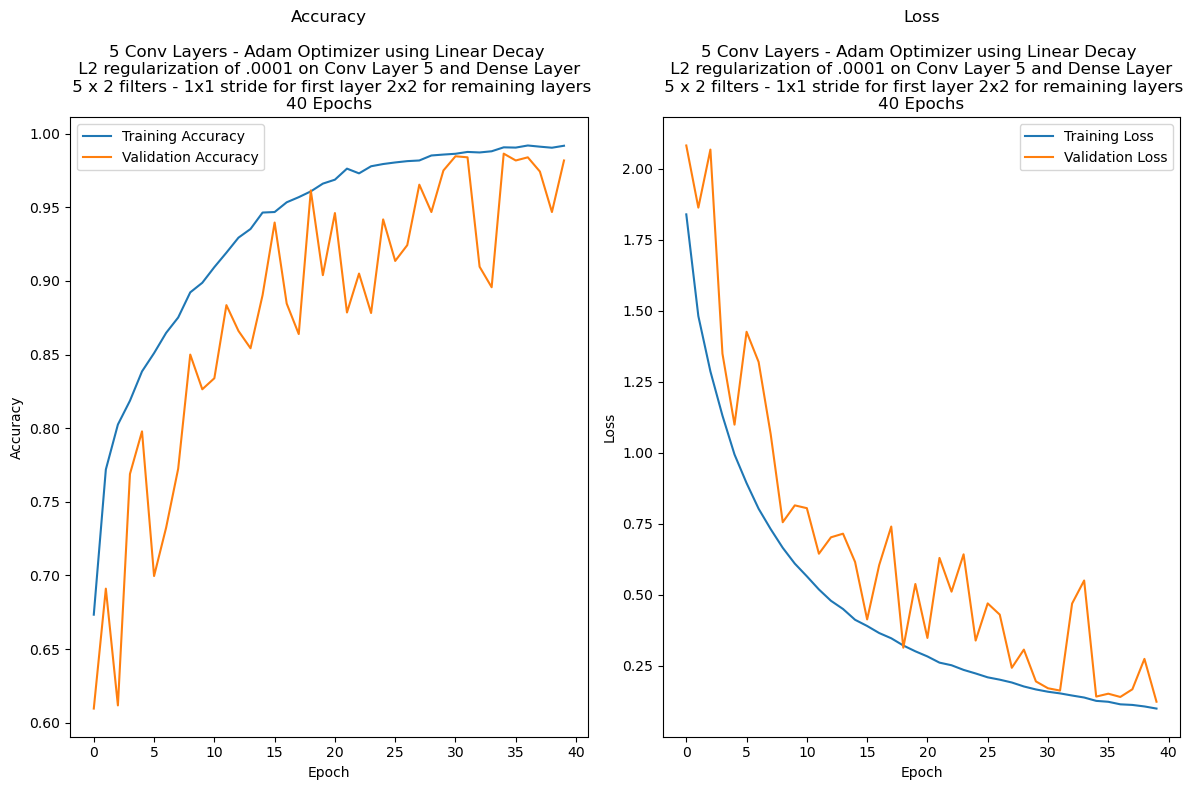

In [30]:
import matplotlib.pyplot as plt

epochs_to_show = min(40, len(history.history['accuracy']))

# Get the optimizer
optimizer = model3.optimizer.get_config()['name']

# model summary
model_details = "5 Conv Layers - Adam Optimizer using Linear Decay \n L2 regularization of .0001 on Conv Layer 5 and Dense Layer \n 5 x 2 filters - 1x1 stride for first layer 2x2 for remaining layers"

# Plot training & validation accuracy values
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'][:epochs_to_show], label='Training Accuracy')
plt.plot(history.history['val_accuracy'][:epochs_to_show], label='Validation Accuracy')
plt.title(f'Accuracy\n\n{model_details}\n{epochs_to_show} Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'][:epochs_to_show], label='Training Loss')
plt.plot(history.history['val_loss'][:epochs_to_show], label='Validation Loss')
plt.title(f'Loss\n\n{model_details}\n{epochs_to_show} Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()



In [31]:
test_loss, test_accuracy = model3.evaluate(x_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

32/32 [==============================] - 1s 16ms/step - loss: 0.1302 - accuracy: 0.9800
Test Accuracy: 98.00%


# Heat maps were helpful for identifying key features in different layers and adjusting the models based on what I saw in them

1/1 [==============================] - 0s 97ms/step


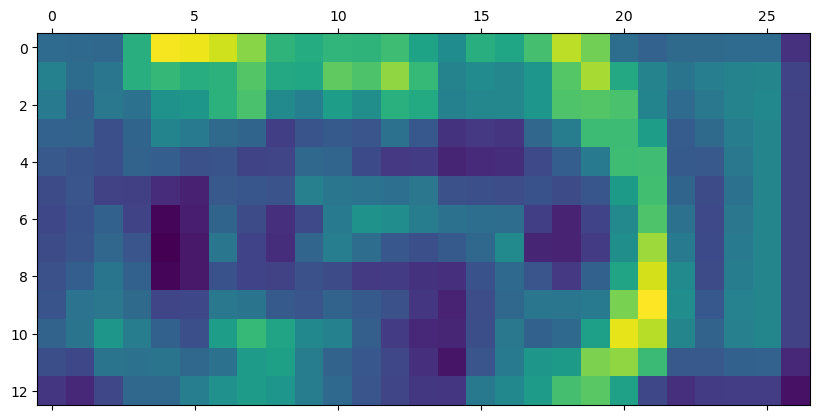

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D

#img_path = 'Data/oasis_data/Very mild Dementia/OAS1_0003_MR1_mpr-1_145.jpg'
img_path = 'Data/oasis_data/Non Demented/OAS1_0001_MR1_mpr-1_145.jpg'

img = load_img(img_path, target_size=(248, 496))  
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Model expects a batch of images


# Create a new model that outputs both the original model's output and the last convolutional layer's feature map
layer_outputs = [layer.output for layer in model3.layers if isinstance(layer, Conv2D)]
activation_model = Model(inputs=model3.input, outputs=layer_outputs)

# Get feature maps
activations = activation_model.predict(img_array)

# Select layer to visualize or average over multiple layers
feature_maps = activations[3]  

# Create heatmap by averaging over all channels and resizing
heatmap = np.mean(feature_maps, axis=-1).squeeze()  # Average across the channels
heatmap = np.maximum(heatmap, 0)  # ReLU to ensure the heatmap is positive
heatmap /= np.max(heatmap)  # Normalize

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Feature maps were also useful in determining if I was extracting features I thought were relevent

In [ ]:
import os
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# function to save feature maps to files
def save_feature_maps(feature_maps, layer_name, save_path):
    num_maps = feature_maps.shape[-1]  # Number of feature maps
    size = feature_maps.shape[1]  # Assuming feature maps are square (size x size)
    n_cols = int(np.sqrt(num_maps))
    n_rows = num_maps // n_cols if num_maps % n_cols == 0 else (num_maps // n_cols) + 1
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
    axes = axes.flatten()
    for i in range(n_rows * n_cols):
        ax = axes[i]
        if i < num_maps:
            ax.imshow(feature_maps[0, :, :, i], cmap='viridis')
        ax.axis('off')
    plt.tight_layout()
    
   
    os.makedirs(save_path, exist_ok=True)  

    # Save the full figure
    fig.savefig(os.path.join(save_path, f'{layer_name}_feature_maps.jpg'))
    plt.close(fig)  # Close the figure after saving to free up memory


save_path = 'Data'  

# Load and preprocess the image
img_path = 'Data/oasis_data/Non Demented/OAS1_0001_MR1_mpr-1_135.jpg'
img = load_img(img_path, target_size=(248, 496))
img_array = img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)  # Add the image to a batch where it's the only member


# Get all the convolutional layers and their names
conv_layers = [(layer, layer.name) for layer in model.layers if isinstance(layer, Conv2D)]

# Create models for each convolutional layer's output and save the feature maps
for layer, layer_name in conv_layers:
    activation_model = Model(inputs=model.input, outputs=layer.output)
    feature_maps = activation_model.predict(img_batch)
    save_feature_maps(feature_maps, layer_name, save_path)

# Print the directory where the images are saved
print(f"Feature maps of non-demented saved to: {save_path}")


# 3.2 Calculate confusion matrix, along with performance metrics

In [34]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support



predictions = (model3.predict(x_val) > 0.5).astype("int32")

# Compute confusion matrix
cm = confusion_matrix(y_val, predictions)
print("Confusion Matrix:")
print(cm)

# Calculate Precision, Recall and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(y_val, predictions, average='binary')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


88/88 [==============================] - 2s 15ms/step
Confusion Matrix:
[[1368   47]
 [   4 1381]]
Precision: 0.9670868347338936
Recall: 0.9971119133574007
F1-score: 0.9818698897973692


# 3.2 K-Fold Cross Validation 
I used 3 splits as I was constrained computationally. This was helpful as in tuning and also verifying the model was generalizing well. 

In [17]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Define the KFold cross-validator
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Prepare arrays to store results
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Enumerate over each fold
for train_index, test_index in kf.split(data_train):
    # Split data
    X_train_fold, X_test_fold = data_train[train_index], data_train[test_index]
    y_train_fold, y_test_fold = labels_train[train_index], labels_train[test_index]
    
    # Define the model
    model = Sequential([
        Conv2D(32, (5, 2), activation='relu', padding='same', input_shape=(248, 496, 3)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (5, 2), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((3, 3)),
        Conv2D(128, (5, 2), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((3, 3)),
        Dropout(0.5),
        Conv2D(256, (5, 2), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        Conv2D(256, (5, 2), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])
    
    # Compile the model
    optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the model
    model.fit(X_train_fold, y_train_fold, epochs=30, batch_size=16)
    
    # Predict on the testing fold
    y_pred_fold = model.predict(X_test_fold).flatten()
    y_pred_classes_fold = (y_pred_fold > 0.5).astype(int)  # Convert probabilities to binary classes
    
    # Compute the metrics
    accuracies.append(accuracy_score(y_test_fold, y_pred_classes_fold))
    precision, recall, f1, _ = precision_recall_fscore_support(y_test_fold, y_pred_classes_fold, average='binary')
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

print(f"Average accuracy: {np.mean(accuracies):.4f}")
print(f"Average precision: {np.mean(precisions):.4f}")
print(f"Average recall: {np.mean(recalls):.4f}")
print(f"Average F1 score: {np.mean(f1_scores):.4f}")


Epoch 1/30
417/417 [==============================] - 18s 39ms/step - loss: 1.9668 - accuracy: 0.6311
Epoch 2/30
417/417 [==============================] - 16s 39ms/step - loss: 1.5682 - accuracy: 0.7439
Epoch 3/30
417/417 [==============================] - 16s 39ms/step - loss: 1.3563 - accuracy: 0.7853
Epoch 4/30
417/417 [==============================] - 16s 39ms/step - loss: 1.1990 - accuracy: 0.8098
Epoch 5/30
417/417 [==============================] - 16s 39ms/step - loss: 1.0740 - accuracy: 0.8216
Epoch 6/30
417/417 [==============================] - 16s 39ms/step - loss: 0.9707 - accuracy: 0.8345
Epoch 7/30
417/417 [==============================] - 16s 39ms/step - loss: 0.8833 - accuracy: 0.8441
Epoch 8/30
417/417 [==============================] - 16s 39ms/step - loss: 0.7884 - accuracy: 0.8590
Epoch 9/30
417/417 [==============================] - 16s 39ms/step - loss: 0.7340 - accuracy: 0.8665
Epoch 10/30
417/417 [==============================] - 16s 39ms/step - loss: 0.671

# 3.3 Visualize the intial results against the K-Fold 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


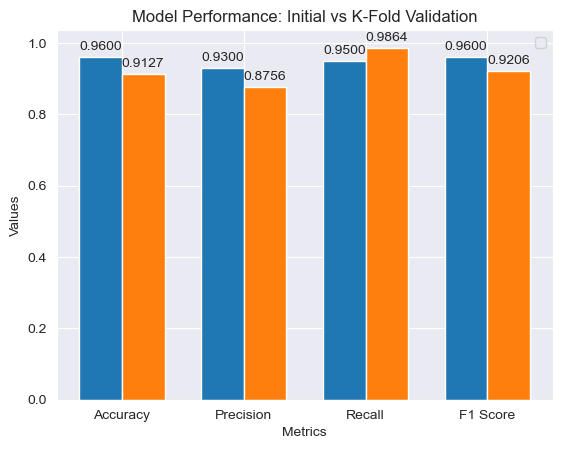

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Data
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
initial_results = [96, 93, 95, 96]  # I mannually put the values in 
kfold_results = [91.27, 87.56, 98.64, 92.06]  # K-fold validation results

# Convert to percentage
initial_results = [x / 100 for x in initial_results]
kfold_results = [x / 100 for x in kfold_results]

# X-axis locations for the groups
ind = np.arange(len(metrics))

# Bar width
width = 0.35

fig, ax = plt.subplots()

# Bars for initial results
initial_bars = ax.bar(ind - width/2, initial_results, width)

# Bars for k-fold results
kfold_bars = ax.bar(ind + width/2, kfold_results, width)

# Labeling
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Model Performance: Initial vs K-Fold Validation')
ax.set_xticks(ind)
ax.set_xticklabels(metrics)
ax.legend()

# Label with the value on top of each bar
def autolabel(bars):
    """Attach a text label above each bar in *bars*, displaying its height."""
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{:.4f}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(initial_bars)
autolabel(kfold_bars)

plt.show()


# 4 Visual of the model architecture. This felt unnessarily difficult and there is 100% space in the market to create easier tools to use for visualizing architectures.

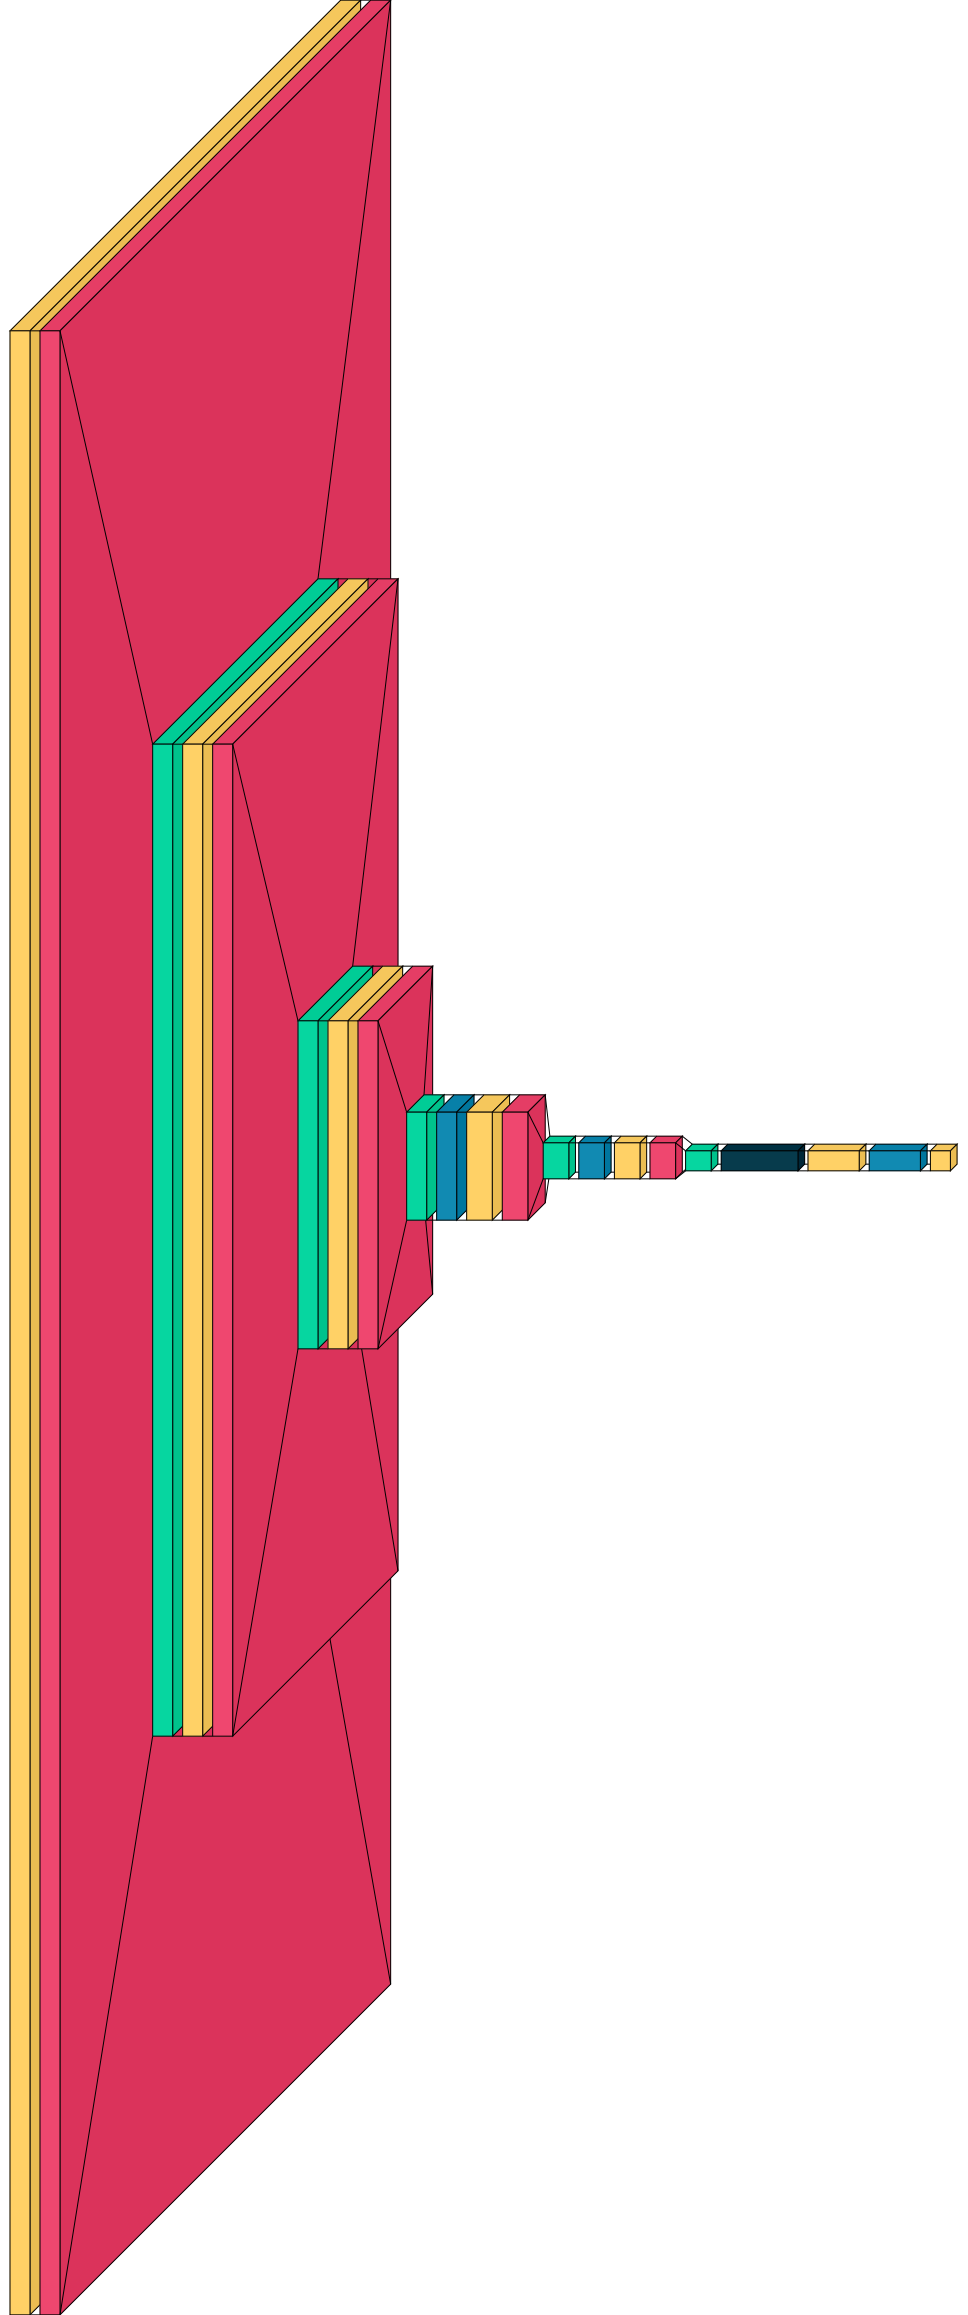

In [38]:
import visualkeras

model = Sequential([
    
    Conv2D(32, (5,5), activation='relu', padding='same', input_shape=(248, 496, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Second convolutional layer with 64 filters
    Conv2D(64, (2,5), activation='relu', padding='same', strides=(1,1)),
    BatchNormalization(),
    MaxPooling2D((3, 3)),

    # Third convolutional layer with 128 filters
    Conv2D(128, (2,5), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((3, 3)),
    Dropout(0.5),

    # Fourth convolutional layer with 256 filters
    Conv2D(256, (2, 5), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((3, 3)),
    Dropout(0.5),

    # fifth convolutional layer with 256 filters
    Conv2D(256, (2, 5), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((3, 3)),
    

    # Flatten the output of the convolutional layers
    Flatten(),

    # dense layer with 512 units
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),

    # Output layer with 4 units (for 4 classes) with softmax activation
    Dense(1, activation='sigmoid')
])


visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='output.png') # write to disk
visualkeras.layered_view(model, to_file='output.png').show() # write and show

visualkeras.layered_view(model)

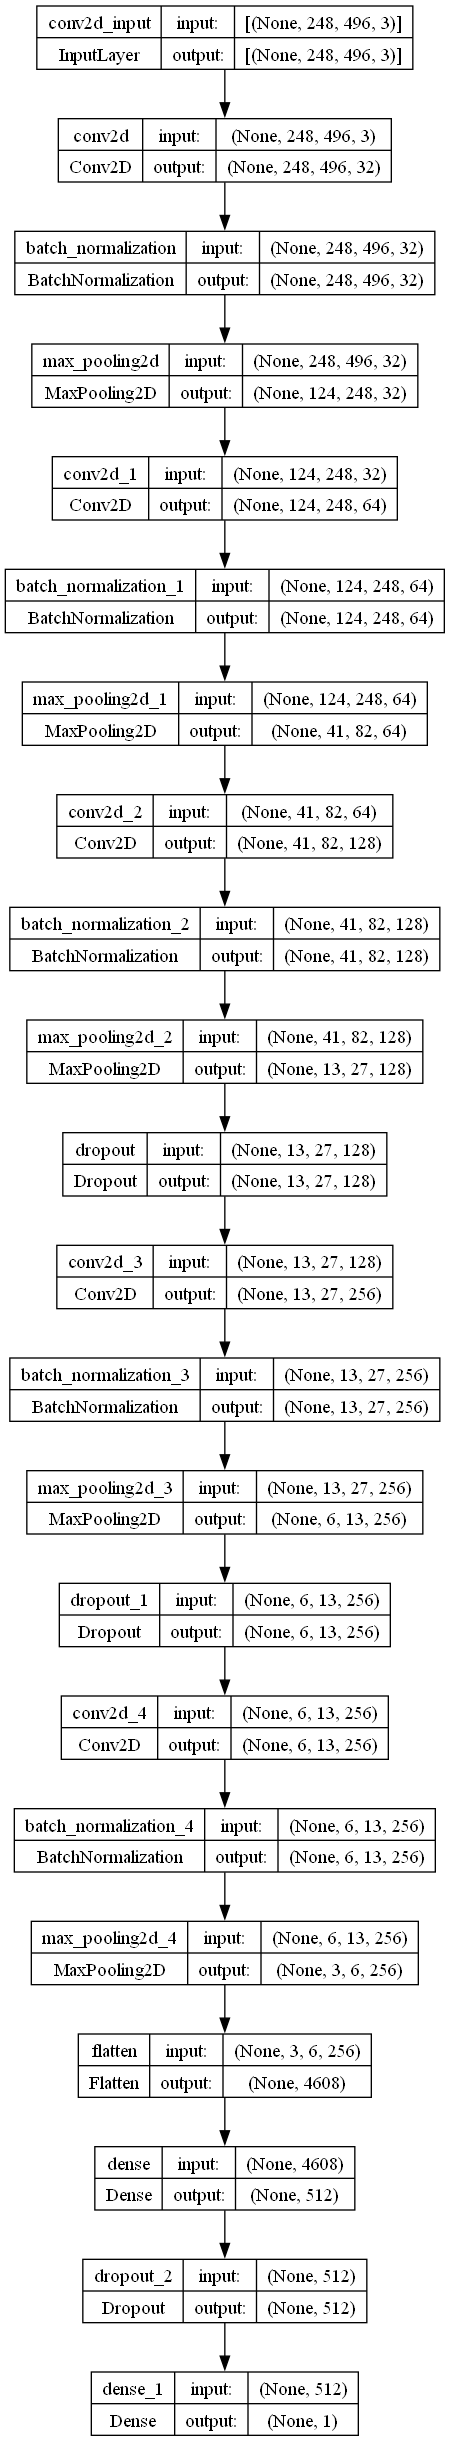

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model

# Define your model
model3 = Sequential([
    Conv2D(32, (5, 2), activation='relu', padding='same', input_shape=(248, 496, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (5, 2), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((3, 3)),
    Conv2D(128, (5, 2), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((3, 3)),
    Dropout(0.5),
    Conv2D(256, (5, 2), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    Conv2D(256, (5, 2), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Generate a plot of your model
plot_model(model3, to_file='model3_architecture.png', show_shapes=True, show_layer_names=True)
